## Basic implementation of Neural Network using numpy


In [113]:
# Use the following command to install required packages

# !pip install numpy
# !pip install pandas
# !pip install matplotlib

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [161]:
class Layer:
    __slots__ = ['weights', 'biases', 'activation', 'biases_gradient', 'weights_gradient', "activation_derivative"]

    def __init__(self, nodes_in, nodes_out, activation='sigmoid'):
        self.weights = np.random.normal(size=(nodes_in, nodes_out),scale=1)
        self.biases = np.random.normal(size=(1, nodes_out))
        self.biases_gradient = np.zeros(self.biases.shape)
        self.weights_gradient = np.zeros(self.weights.shape)
        if activation == 'sigmoid':
            self.activation = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation == 'linear':
            self.activation = self.linear
            self.activation_derivative = self.linear_derivative

    def calculate_layer(self, input):
        """
        Calculate the output of the layer
        Takes in a numpy array and returns a numpy array
        """
        return self.activation(np.dot(input, self.weights) + self.biases)

    def sigmoid(self, x):
        """
        Sigmoid activation function
        Takes in a numpy array and returns a numpy array
        """
        return 1/(1+np.exp(-x))

    def sigmoid_derivative(self, x):
        """
        Sigmoid derivative function
        Takes in a numpy array and returns a numpy array
        """
        return x * (1 - x)

    def linear(self, x):
        """
        Linear activation function
        Takes in a numpy array and returns a numpy array
        """
        return x

    def linear_derivative(self, x):
        """
        Linear derivative function
        Takes in a numpy array and returns a numpy array
        """
        return np.ones_like(x)

    def report_layer(self, layer_num):
        return f'Layer number {layer_num}\nWeights\n{self.weights}\nbiases\n{self.biases}'

    def apply_gradient(self, learning_rate):
        self.weights -= learning_rate * self.weights_gradient
        self.biases -= learning_rate * self.biases_gradient

In [150]:
class NeuralNetwork:
    __slots__ = ['hidden_layers', 'layers']

    def __init__(self, hidden_layers, input_size, output_size):
        self.hidden_layers = hidden_layers
        self.layers = []

        # Create the input layer
        input_layer = Layer(1, hidden_layers[0])
        self.layers.append(input_layer)

        # Create the hidden layers
        for input_size, output_size in zip(hidden_layers, hidden_layers[1:]):
            self.layers.append(Layer(input_size, output_size))

        # Create the output layer
        output_layer = Layer(hidden_layers[-1], 1, activation='linear')
        self.layers.append(output_layer)

    def forward(self, input):
        """
        Takes a input and returns the output of the network
        """
        for layer in self.layers:
            input = layer.calculate_layer(input)
        return input

    def train(self, input, output, learning_rate=0.003, batch_size_frac=0.1):
        """
        Train the network on a given dataset
        """
        for epoch in range(20000):
            merged = input.to_frame().join(output)
            merged = merged.sample(frac=batch_size_frac)
            self.calculate_gradient(merged["x"], merged["y"])
            self.apply_gradient(learning_rate)
            if epoch % 1000 == 0:
                print(f'Epoch {epoch} MSE: {self.mean_squared_error(input, output)}')

    def backpropagation(self, input, output):
        """
        Perform backpropagation on the network
        """
        pass

    def mean_squared_error(self, input, output):
        """
        Calculate the mean squared error of the network on a given dataset and output
        """
        mse = []
        for i,j in zip(input, output):
            mse.append((j - self.forward(i)) ** 2)
        return np.mean(mse)

    def mean_squared_error_gradient(self, predicted, true):
        """
        Calculate the gradient of the mean squared error
        """
        return 2 * (predicted - true)

    def visualize(self):
        """
        Visualize the network architecture
        """
        for i, layer in enumerate(self.layers):
            print(layer.report_layer(i))
            print("\n")

    def apply_gradient(self, learning_rate):
        for layer in self.layers:
            layer.apply_gradient(learning_rate)

    def calculate_gradient(self, input, output):
        """
        Calculate the gradient of the network
        """
        h = 0.0001
        original_mse = self.mean_squared_error(input, output)

        for layer in self.layers:
            for i in range(layer.weights.shape[0]):
                for j in range(layer.weights.shape[1]):
                    layer.weights[i, j] += h
                    new_mse = self.mean_squared_error(input, output)
                    layer.weights_gradient[i, j] = (new_mse - original_mse) / h
                    layer.weights[i, j] -= h

            for i in range(layer.biases.shape[0]):
                for j in range(layer.biases.shape[1]):
                    layer.biases[i, j] += h
                    new_mse = self.mean_squared_error(input, output)
                    layer.biases_gradient[i, j] = (new_mse - original_mse) / h
                    layer.biases[i, j] -= h

# First set

In [117]:
square_simple = pd.read_csv('../data/regression/square-simple-test.csv', index_col=0)

,x,y
1,-0.980437,-43.486918
2,-1.219074,3.752808
3,0.124243,-128.610721
4,1.227789,5.671828
5,1.067348,-27.469169
...,...,...
96,1.315377,25.719403
97,-1.196968,-1.054107
98,1.544766,84.767303
99,0.441051,-112.492699


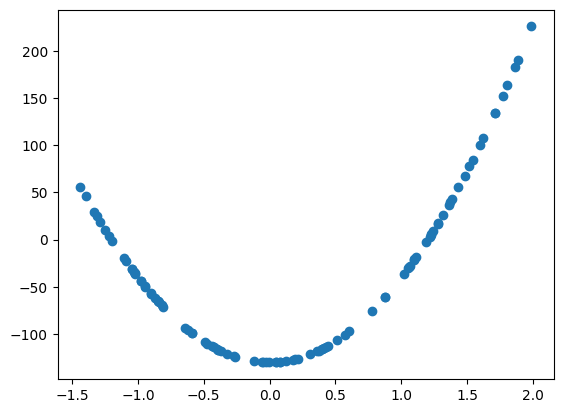

In [118]:
# scater plot of the data
plt.scatter(square_simple['x'], square_simple['y'])
square_simple

In [149]:
neural1 = NeuralNetwork([5], 1, 1)
neural1.mean_squared_error(square_simple["x"], square_simple["y"])
neural1.train(square_simple["x"], square_simple["y"], learning_rate=0.001)
neural1.mean_squared_error(square_simple["x"], square_simple["y"])

Epoch 0 MSE: 8679.263084954373
Epoch 500 MSE: 4428.97543548325
Epoch 1000 MSE: 3855.1894038438586
Epoch 1500 MSE: 3459.6134370439327
Epoch 2000 MSE: 3165.210056896297
Epoch 2500 MSE: 2962.014716590586
Epoch 3000 MSE: 2787.937048979415
Epoch 3500 MSE: 2641.294575795045
Epoch 4000 MSE: 2521.8159893335087
Epoch 4500 MSE: 2434.5490541000872
Epoch 5000 MSE: 2353.641328387205
Epoch 5500 MSE: 2287.583060941818
Epoch 6000 MSE: 2228.757919971742
Epoch 6500 MSE: 2177.36432446854
Epoch 7000 MSE: 2134.830136810954
Epoch 7500 MSE: 2098.1387759166323
Epoch 8000 MSE: 2066.03097940749
Epoch 8500 MSE: 2036.1470766848238
Epoch 9000 MSE: 2011.4740476934237
Epoch 9500 MSE: 1987.061178710477
Epoch 10000 MSE: 1966.3307222340995
Epoch 10500 MSE: 1948.5886479703709
Epoch 11000 MSE: 1934.3520307121084
Epoch 11500 MSE: 1918.194678210828
Epoch 12000 MSE: 1907.0193041734094
Epoch 12500 MSE: 1893.582949683053
Epoch 13000 MSE: 1882.8271082959557
Epoch 13500 MSE: 1872.5496625068063
Epoch 14000 MSE: 1861.147939681199

1793.0134591234248

Layer number 0
Weights
[[-10.55797225 -11.48267626 -11.44710805 -14.08859405 -10.0563897 ]]
biases
[[ 13.77022818  15.41418215   9.02299985 -11.95047704  10.03130811]]


Layer number 1
Weights
[[-47.98674309]
 [-51.63075023]
 [-39.59299594]
 [ 73.42935549]
 [-47.50487271]]
biases
[[83.89645855]]


None


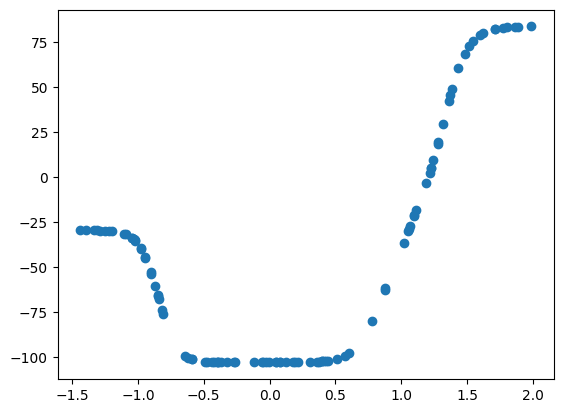

In [120]:
y = []
for i in square_simple["x"]:
    y.append(neural1.forward(i))
plt.scatter(square_simple["x"], y, c="red")
plt.scatter(square_simple["x"], square_simple["y"], c="blue")
plt.legend(["Prediction", "True"])
print(neural1.visualize())

# try how its working on normalized dataset

Epoch 0 MSE: 5.525179802116549
Epoch 1000 MSE: 0.4022185018962701
Epoch 2000 MSE: 0.1555554187737936
Epoch 3000 MSE: 0.07817244816876695
Epoch 4000 MSE: 0.05221907610755138
Epoch 5000 MSE: 0.03981531304628361
Epoch 6000 MSE: 0.03183962870677251
Epoch 7000 MSE: 0.02669742326817032
Epoch 8000 MSE: 0.02289616028977745
Epoch 9000 MSE: 0.01963851129184995
Epoch 10000 MSE: 0.017048060016958445
Epoch 11000 MSE: 0.015111805877204154
Epoch 12000 MSE: 0.013394727998962973
Epoch 13000 MSE: 0.011953523386445659
Epoch 14000 MSE: 0.01080304734968702
Epoch 15000 MSE: 0.009751246125157965
Epoch 16000 MSE: 0.008847192518334143
Epoch 17000 MSE: 0.008087260646544445
Epoch 18000 MSE: 0.007330391267292878
Epoch 19000 MSE: 0.006720324134644181


0.00621268581659434

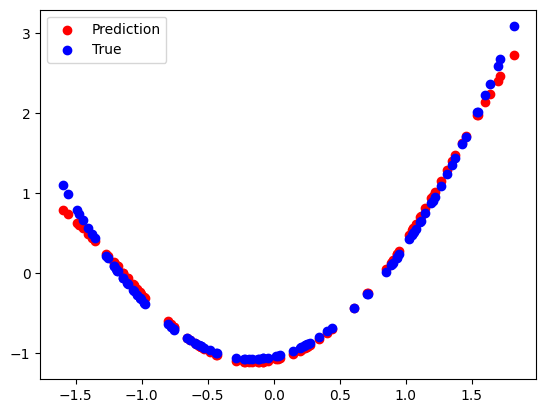

In [162]:
# normalize the data
square_simple_normalized = square_simple.copy()
square_simple_normalized["x"] = (square_simple["x"] - square_simple["x"].mean()) / square_simple["x"].std()
square_simple_normalized["y"] = (square_simple["y"] - square_simple["y"].mean()) / square_simple["y"].std()

# train the network
neural1 = NeuralNetwork([5], 1, 1)
neural1.mean_squared_error(square_simple_normalized["x"], square_simple_normalized["y"])
neural1.train(square_simple_normalized["x"], square_simple_normalized["y"], learning_rate=0.007, batch_size_frac=0.05)
neural1.mean_squared_error(square_simple_normalized["x"], square_simple_normalized["y"])

# plot the result
y = []
for i in square_simple_normalized["x"]:
    y.append(neural1.forward(i))
plt.scatter(square_simple_normalized["x"], y, c='red')
plt.scatter(square_simple_normalized["x"], square_simple_normalized['y'], c='blue')
plt.legend(["Prediction", "True"])
neural1.mean_squared_error(square_simple_normalized["x"], square_simple_normalized["y"])

Epoch 0 MSE: 8901.711569055267
Epoch 1000 MSE: 1913.9521842324625
Epoch 2000 MSE: 1835.8646975388092
Epoch 3000 MSE: 1769.873292675151
Epoch 4000 MSE: 1786.4247577840451
Epoch 5000 MSE: 1900.218182089751
Epoch 6000 MSE: 1891.4805733123376
Epoch 7000 MSE: 1838.1864457575589
Epoch 8000 MSE: 1814.3560329062093
Epoch 9000 MSE: 1836.11627140791
Epoch 10000 MSE: 1927.5361818132706
Epoch 11000 MSE: 2219.040378476904
Epoch 12000 MSE: 2475.9346212512573
Epoch 13000 MSE: 1902.4119927290114
Epoch 14000 MSE: 1993.7025602250756
Epoch 15000 MSE: 2688.0143500060094
Epoch 16000 MSE: 1940.059513590181
Epoch 17000 MSE: 1870.78320567816
Epoch 18000 MSE: 2246.665959693195
Epoch 19000 MSE: 1918.634948789673
Layer number 0
Weights
[[-84.68729662 -15.12826419 -73.14393115  46.17476904 -78.16246115]]
biases
[[ 134.25284295   49.14670874   68.52969622 -101.00603466   96.38724816]]


Layer number 1
Weights
[[-95.54585017]
 [-65.07874101]
 [-71.53081769]
 [ 89.17713994]
 [-80.87147565]]
biases
[[222.65316922]]



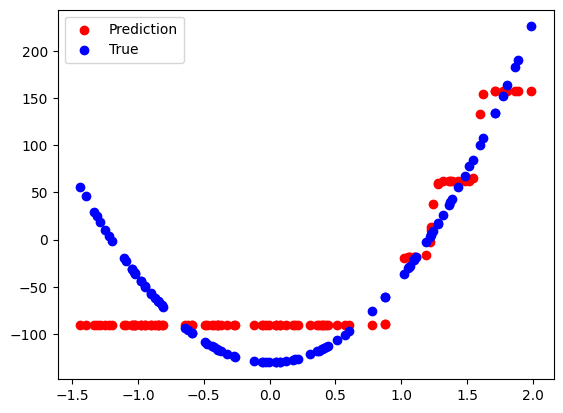

In [164]:
neural1 = NeuralNetwork([5], 1, 1)
neural1.mean_squared_error(square_simple["x"], square_simple["y"])
neural1.train(square_simple["x"], square_simple["y"], learning_rate=0.01, batch_size_frac=0.03)
neural1.mean_squared_error(square_simple["x"], square_simple["y"])
y = []
for i in square_simple["x"]:
    y.append(neural1.forward(i))
plt.scatter(square_simple["x"], y, c="red")
plt.scatter(square_simple["x"], square_simple["y"], c="blue")
plt.legend(["Prediction", "True"])
print(neural1.visualize())

2.255982606987352

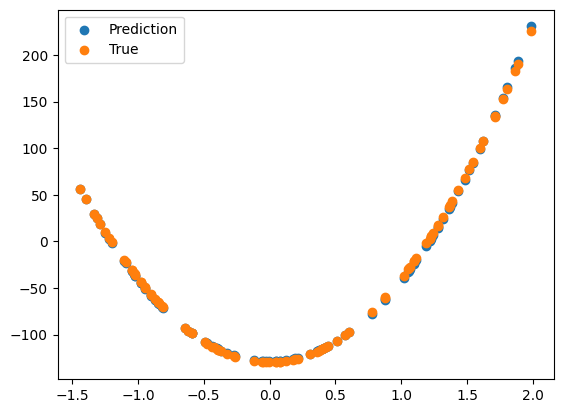

In [153]:
neural1.layers[0].biases =  np.array([[-2.9,-2.8897,-2.8897,-2.8897,-2.8897]])
neural1.layers[0].weights = np.array([[-0.9733, -0.9733, -0.9733, -0.9733, 0.9733]])
neural1.layers[1].weights = np.array([[502], [502], [502], [502], [1993]])
neural1.layers[1].biases = np.array([[-339.16]])
y = []
for i in square_simple["x"]:
    y.append(neural1.forward(i))
plt.scatter(square_simple["x"], y)
plt.scatter(square_simple["x"], square_simple["y"])
plt.legend(["Prediction", "True"])
neural1.mean_squared_error(square_simple["x"], square_simple["y"])

In [122]:
neural2 = NeuralNetwork([10], 1, 1)
neural2.mean_squared_error(square_simple['x'], square_simple['y'])
neural2.train(square_simple["x"], square_simple["y"])
neural2.mean_squared_error(square_simple["x"], square_simple["y"])

Epoch 0 MSE: 8518.197917834665
Epoch 100 MSE: 4120.927173130985
Epoch 200 MSE: 3281.1654997192645
Epoch 300 MSE: 2815.8021082344385
Epoch 400 MSE: 2497.7033372215637
Epoch 500 MSE: 2255.370434621555
Epoch 600 MSE: 2056.5821541740625
Epoch 700 MSE: 1884.6788506887608
Epoch 800 MSE: 1730.6070329439679
Epoch 900 MSE: 1591.2535635561674
Epoch 1000 MSE: 1465.8999108095952
Epoch 1100 MSE: 1353.746856082552
Epoch 1200 MSE: 1253.4925289353337
Epoch 1300 MSE: 1163.5934820167463
Epoch 1400 MSE: 1082.7852895288154
Epoch 1500 MSE: 1010.1034493309853
Epoch 1600 MSE: 944.6730281351047
Epoch 1700 MSE: 885.6329970638653
Epoch 1800 MSE: 832.1469390789509
Epoch 1900 MSE: 783.4554128400548


739.3609841230829

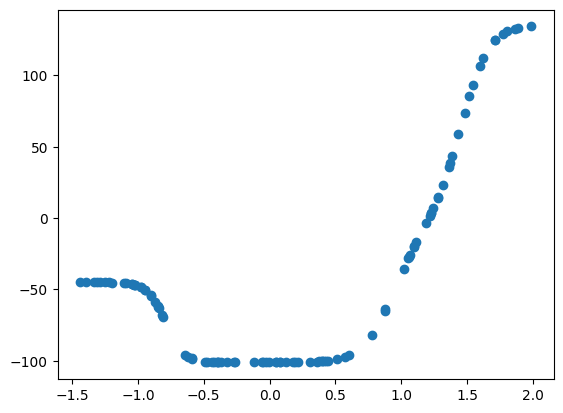

In [123]:
y = []
for i in square_simple["x"]:
    y.append(neural2.forward(i))
plt.scatter(square_simple["x"], y)

In [124]:
neural3 = NeuralNetwork([5, 5], 1, 1)
neural3.mean_squared_error(square_simple['x'], square_simple['y'])
# neural3.train(square_simple["x"], square_simple["y"])
# neural3.mean_squared_error(square_simple["x"], square_simple["y"])

8665.260439367577

# Second set

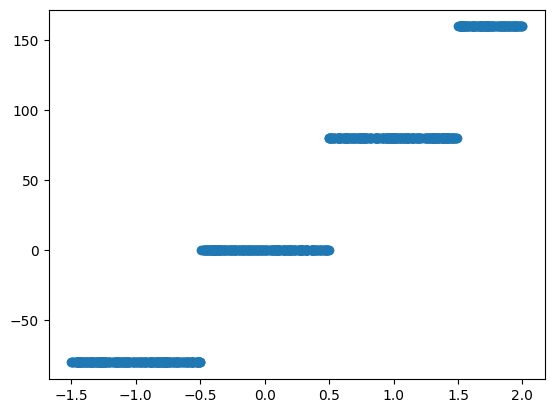

In [125]:
steps_large = pd.read_csv("../data/regression/steps-large-test.csv", index_col=0)
plt.scatter(steps_large["x"], steps_large["y"])

In [126]:
neural4 = NeuralNetwork([5], 1, 1)
neural4.mean_squared_error(steps_large["x"], steps_large["y"])
neural4.train(steps_large["x"], steps_large["y"])
neural4.mean_squared_error(steps_large["x"], steps_large["y"])

Epoch 0 MSE: 7331.0497641310485
Epoch 100 MSE: 2993.7307737129927
Epoch 200 MSE: 1672.454099640688
Epoch 300 MSE: 1191.7054310157607
Epoch 400 MSE: 893.5021904920021
Epoch 500 MSE: 691.9812168242296
Epoch 600 MSE: 544.3503907951681
Epoch 700 MSE: 442.70303349866646
Epoch 800 MSE: 376.5310429442026
Epoch 900 MSE: 332.834129225353
Epoch 1000 MSE: 302.3667858002931
Epoch 1100 MSE: 279.53205061720286
Epoch 1200 MSE: 260.87308087816285
Epoch 1300 MSE: 243.67952023388892
Epoch 1400 MSE: 226.73172295880758
Epoch 1500 MSE: 212.7097792262382
Epoch 1600 MSE: 201.66064997942624
Epoch 1700 MSE: 192.4936398068851
Epoch 1800 MSE: 184.69549106872972
Epoch 1900 MSE: 177.95235987213871


172.09377230063652

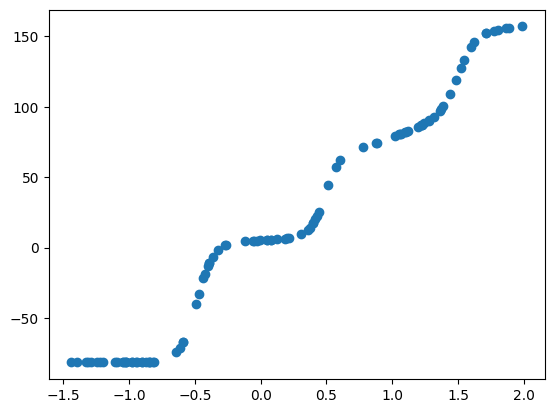

In [127]:
y = []
for i in square_simple["x"]:
    y.append(neural4.forward(i))
plt.scatter(square_simple["x"], y)

In [133]:
neural5 = NeuralNetwork([10], 1, 1)
neural5.mean_squared_error(steps_large["x"], steps_large["y"])
# neural5.train(steps_large["x"], steps_large["y"])
# neural5.mean_squared_error(steps_large["x"], steps_large["y"])

7560.0669420173335

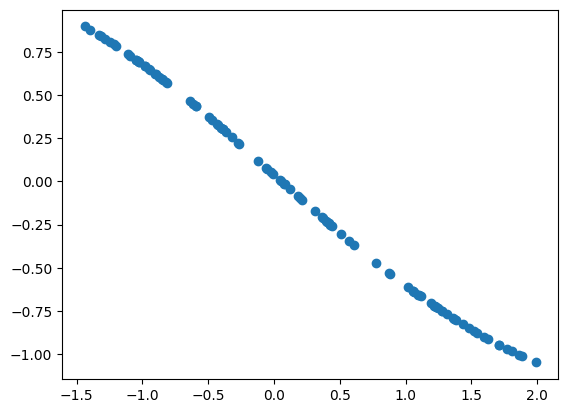

In [134]:
y = []
for i in square_simple["x"]:
    y.append(neural5.forward(i))
plt.scatter(square_simple["x"], y)

In [ ]:
neural6 = NeuralNetwork([5,5], 1, 1)
neural6.mean_squared_error(steps_large["x"], steps_large["y"])